# Freewheeling Diode

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.

It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, cpu_count
from PySpice.Spice.Netlist import (
    Circuit, SubCircuitFactory
)
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Introduction

Freewheeling diodes are **essential components** used to protect circuits from damage caused by sudden voltage spikes. They are often found in systems involving **inductive elements**, such as coils, motors, or relays, and should **never be omitted** when switching inductive loads.

These diodes are typically connected **in parallel with the inductive load** (coil), as shown in the figure below. When the circuit switches from a closed to an open state, a **transient overvoltage** can occur due to the energy stored in the magnetic field of the inductor.
In the next section, we will explain **why** this overvoltage appears.


```{figure} ./images/diode_roue_libre_problem.svg
:name: diode-roue-libre
:align: center
:width: 500px

Freewheel diode assembly problem
```



## Problem Statement

```{figure} ./images/montage_pose_problem.svg
:name: montage-pose-problem
:align: center
:width: 500px

Freewheeling Diode Study Assembly
```


To understand the issue, consider the following circuit.
It consists of four main elements:

* an **inductance** $L$,
* its **series resistance** $r$,
* a **switch** (which opens and closes the circuit),
* and a **voltage source**.

The voltage across the inductor is defined as:

$$
v(t) = L \frac{di(t)}{dt}
$$

When the switch is **closed**, the loop equation is:

$$
V_\text{in} = V_r + V_\text{ind}
$$

Substituting the terms, we get:

$$
V_\text{in} = L \frac{di(t)}{dt} + r \cdot i(t)
$$

However, when the switch **opens suddenly**, the current through the inductor attempts to drop instantly from a value $i(t_0)$ to zero.
Mathematically, this implies:

$$
\frac{di(t)}{dt} \to \infty
$$

As a result, the inductor generates a **very large voltage spike** in an attempt to maintain the current flow.
This overvoltage can easily **exceed the breakdown voltage** of components and **destroy the circuit**.

In conclusion, without a freewheeling diode, **every time the circuit is disconnected, a destructive voltage surge will occur**.

To visualize the behavior described above, we use the circuit shown in the [](#diode_roue_libre_1_spice).

```{figure} ./images/diode_roue_libre_1_spice.svg
:name: diode_roue_libre_1_spice
:align: center
:width: 500px

Initial circuit (no flyback diode)
```

This first setup shows the inductive load switched directly by the interrupting device (no freewheeling diode present).
It is used to demonstrate the transient overvoltage that occurs when the switch opens — the exact problem the flyback diode is intended to prevent.

In [3]:
# ============================================================
# Circuit Definition
# ============================================================

circuit = Circuit('RL Circuit with Voltage and Current Control')

# ------------------------------------------------------------
# Voltage Source (10 V)
# ------------------------------------------------------------
circuit.V('1', 'in', circuit.gnd, 10@u_V)

# ------------------------------------------------------------
# Passive Components
# ------------------------------------------------------------
circuit.R('1', 'in', 'n1', 100@u_Ohm)     # Resistor: 100 Ω
circuit.L('1', 'n1', 'out', 10@u_mH)      # Inductor: 10 mH

# ------------------------------------------------------------
# Controlled Switch
# ------------------------------------------------------------
circuit.S('1', 'out', circuit.gnd, 'ctrl', circuit.gnd, model='SW')

# Switch Model Parameters
circuit.model(
    'SW',
    'SW',
    Ron=1@u_mOhm,     # ON resistance: 1 mΩ
    Roff=1@u_MOhm,    # OFF resistance: 1 MΩ
    Vt=0.5@u_V        # Threshold voltage: 0.5 V
)

# ------------------------------------------------------------
# Control Voltage Source
# ------------------------------------------------------------
# Produces 1 V (switch closed) until 2 ms, then 0 V (switch open)
circuit.V(
    'ctrl',
    'ctrl',
    circuit.gnd,
    'PULSE(1 0 2m 1n 1n 10m 20m)'
)
# ============================================================
# End of Circuit Definition
# ============================================================

Node name 'in' is a Python keyword


.title RL Circuit with Voltage and Current Control
V1 in 0 10V
R1 in n1 100Ohm
L1 n1 out 10mH
S1 out 0 ctrl 0 SW
Vctrl ctrl 0 PULSE(1 0 2m 1n 1n 10m 20m)
.model SW SW (Roff=1MegOhm Ron=1mOhm Vt=0.5V)



In [4]:
# ============================================================
# Simulation Setup
# ============================================================

# Create simulator instance
simulator = circuit.simulator(
    temperature=25,             # Simulation temperature (°C)
    nominal_temperature=25      # Nominal device temperature (°C)
)

# Run transient analysis
analysis = simulator.transient(
    step_time=1@u_us,           # Simulation time step: 1 µs
    end_time=5@u_ms             # Total simulation time: 5 ms
)

# ============================================================
# Data Extraction
# ============================================================

# Convert simulation results to NumPy arrays
time = np.array(analysis.time)

# Voltage across the inductor (Vn1 - Vout)
voltage_L = np.array(analysis['in']) - np.array(analysis['out'])

# Circuit current (same as current through the inductor)
current = np.array(analysis.branches['v1'])

# ============================================================
# End of Simulation
# ============================================================

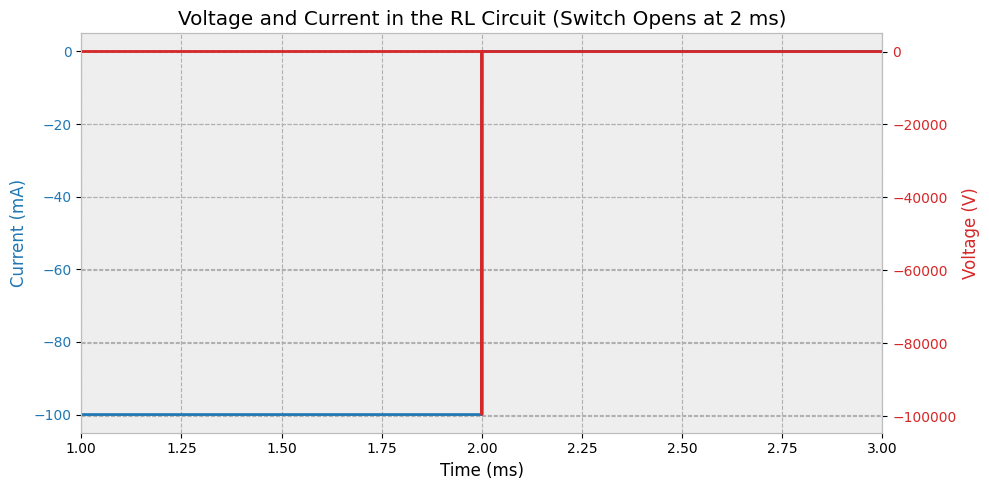

In [5]:
# ============================================================
# Plotting: Dual-Axis Graph
# ============================================================

fig, ax1 = plt.subplots(figsize=(10, 5))

# ------------------------------------------------------------
# Left Axis: Current (A)
# ------------------------------------------------------------
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current (mA)', color='tab:blue')
ax1.plot(time * 1e3, current*1e3, color='tab:blue', label='Current')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ------------------------------------------------------------
# Right Axis: Inductor Voltage (V)
# ------------------------------------------------------------
ax2 = ax1.twinx()
ax2.set_ylabel('Voltage (V)', color='tab:red')
ax2.plot(time * 1e3, voltage_L, color='tab:red', label='Inductor Voltage')
ax2.tick_params(axis='y', labelcolor='tab:red')

# ------------------------------------------------------------
# Title and Layout
# ------------------------------------------------------------
plt.xlim(1, 3)
plt.title('Voltage and Current in the RL Circuit (Switch Opens at 2 ms)')
fig.tight_layout()
plt.show()

# ============================================================
# End of Plotting Section
# ============================================================

On the graph below, two curves can be observed:

* the **blue curve** represents the **current** flowing through the inductor,
* the **red curve** shows the **voltage** across it.

When the **switch opens at 2 ms**, the **current** (blue curve) drops abruptly from **100 mA to 0 A**.
However, the **voltage** across the inductance reacts violently — it rises from 0 V to about **–100 000 V**, which is an enormous value that can easily **damage or destroy circuit components**.

This behavior is due to a fundamental property of inductors:
they **oppose any rapid change in current**.
When the current is suddenly interrupted, the inductor generates a very high voltage in an attempt to maintain the current flow — resulting in a dangerous voltage spike.

The next section aims to **address this issue** and prevent such overvoltage.

## Solving the Problem

To prevent this destructive voltage spike, a **flyback diode** (also known as a **freewheeling diode**) is added **in reverse bias** across the inductor.

The updated circuit is shown below (see [](#diode_roue_libre_2_spice)).

The operation of the diode can be divided into two distinct phases:

* **When the switch is closed:**
  the diode is **reverse-biased**, meaning it behaves like an **open circuit** with a very high resistance.
  Therefore, it has **no effect** on the normal operation of the circuit — the current flows only through the resistor and the inductor.

* **When the switch opens:**
  the voltage across the inductor **rises sharply** as it attempts to maintain the current.
  Once this voltage exceeds the **forward voltage threshold** of the diode, the diode **turns on**, providing a **path for the current** to circulate through the inductor and diode loop.
  This process **limits the voltage spike** and **protects the rest of the circuit** from damage.


```{figure} ./images/diode_roue_libre_2_spice.svg
:name: diode_roue_libre_2_spice
:align: center
:width: 500px

Initial circuit with flyback diode
```

In [9]:
# ============================================================
# Circuit Definition
# ============================================================

circuit = Circuit('RL Circuit with Voltage and Current Control')
circuit.include('lib/diodes_standard-rectifiers.lib')

# ------------------------------------------------------------
# Voltage Source (10 V)
# ------------------------------------------------------------
circuit.V('1', 'in', circuit.gnd, 10@u_V)

# ------------------------------------------------------------
# Passive Components
# ------------------------------------------------------------
circuit.R('1', 'in', 'n1', 100@u_Ohm)             # Resistor: 100 Ω
circuit.L('1', 'n1', 'out', 10@u_mH)              # Inductor: 10 mH
circuit.D('1', 'out', 'in', model='DI_1N4004GL')  # Diode  : 1N4004GL

# ------------------------------------------------------------
# Controlled Switch
# ------------------------------------------------------------
circuit.S('1', 'out', circuit.gnd, 'ctrl', circuit.gnd, model='SW')

# Switch Model Parameters
circuit.model(
    'SW',
    'SW',
    Ron=1@u_mOhm,     # ON resistance: 1 mΩ
    Roff=1@u_MOhm,    # OFF resistance: 1 MΩ
    Vt=0.5@u_V        # Threshold voltage: 0.5 V
)

# ------------------------------------------------------------
# Control Voltage Source
# ------------------------------------------------------------
# Produces 1 V (switch closed) until 2 ms, then 0 V (switch open)
circuit.V(
    'ctrl',
    'ctrl',
    circuit.gnd,
    'PULSE(1 0 2m 1n 1n 10m 20m)'
)
# ============================================================
# End of Circuit Definition
# ============================================================

Node name 'in' is a Python keyword


.title RL Circuit with Voltage and Current Control
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\General\lib\diodes_standard-rectifiers.lib
V1 in 0 10V
R1 in n1 100Ohm
L1 n1 out 10mH
D1 out in DI_1N4004GL
S1 out 0 ctrl 0 SW
Vctrl ctrl 0 PULSE(1 0 2m 1n 1n 10m 20m)
.model SW SW (Roff=1MegOhm Ron=1mOhm Vt=0.5V)



In [10]:
# ============================================================
# Simulation Setup
# ============================================================

# Create simulator instance
simulator = circuit.simulator(
    temperature=25,             # Simulation temperature (°C)
    nominal_temperature=25      # Nominal device temperature (°C)
)

# Run transient analysis
analysis = simulator.transient(
    step_time=1@u_us,           # Simulation time step: 1 µs
    end_time=5@u_ms             # Total simulation time: 5 ms
)

# ============================================================
# Data Extraction
# ============================================================

# Convert simulation results to NumPy arrays
time = np.array(analysis.time)

# Voltage across the inductor (Vn1 - Vout)
voltage_L = np.array(analysis['in']) - np.array(analysis['out'])

# Circuit current (same as current through the inductor)
current = np.array(analysis.branches['v1'])

# ============================================================
# End of Simulation
# ============================================================

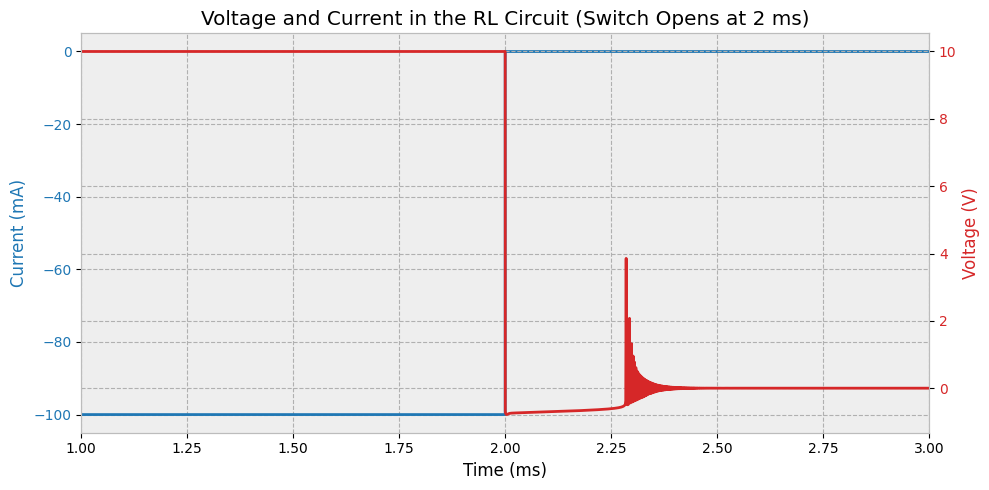

In [11]:
# ============================================================
# Plotting: Dual-Axis Graph
# ============================================================

fig, ax1 = plt.subplots(figsize=(10, 5))

# ------------------------------------------------------------
# Left Axis: Current (A)
# ------------------------------------------------------------
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current (mA)', color='tab:blue')
ax1.plot(time * 1e3, current*1e3, color='tab:blue', label='Current')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ------------------------------------------------------------
# Right Axis: Inductor Voltage (V)
# ------------------------------------------------------------
ax2 = ax1.twinx()
ax2.set_ylabel('Voltage (V)', color='tab:red')
ax2.plot(time * 1e3, voltage_L, color='tab:red', label='Inductor Voltage')
ax2.tick_params(axis='y', labelcolor='tab:red')

# ------------------------------------------------------------
# Title and Layout
# ------------------------------------------------------------
plt.xlim(1, 3)
plt.title('Voltage and Current in the RL Circuit (Switch Opens at 2 ms)')
fig.tight_layout()
plt.show()

# ============================================================
# End of Plotting Section
# ============================================================

We can observe that this time, the extreme voltage spike of –100,000 V no longer occurs, so the electronic board is no longer at risk of damage.

### Why These Oscillations Occur

* **1. Contact opening → sudden overvoltage**
When the switch (**K**) opens, the current flowing through the inductor tries to continue due to the energy stored in its magnetic field. The small **parasitic capacitance** ( C_1 ) of the wiring charges very quickly, causing a**sharp voltage spike** across the opening contacts.
If this voltage exceeds the **dielectric strength of the air**, a **breakdown (arc)** occurs.

* **2. Arc formation → repetitive voltage pulses**
Once the arc forms, the voltage drops to about **15 V**, discharging ( C_1 ).
As soon as the arc extinguishes, ( C_1 ) starts charging again — until another breakdown happens.
This creates a **repetitive pulse sequence**, continuing until the contact separation becomes large enough to stop arcing.
Each breakdown generates **high-frequency electromagnetic interference**, because fast transients produce a **broadband spectrum**.

* **3. LC ringing (resonance)**
The combination of the **inductance** ( L ) (from the coil and wiring) and the **parasitic capacitance** ( C_1 ) forms an **LC resonant circuit**.
After each pulse or after the contact fully opens, the energy exchange between ( L ) and ( C_1 ) causes a **damped oscillation** at the natural frequency:

$$f_0 = \frac{1}{2\pi\sqrt{L C_1}}$$

This ringing explains the small oscillations often observed after the switch opens, even when the diode or damping network is present.

## Conclusion

Conclusion: never forget to include flyback diodes in circuits with inductive loads. They are crucial for protecting components from high-voltage transients.

Some examples of circuits where flyback diodes are commonly used include:

- …

**Theoretical References:**

[**Diode**](../Base_componant/diode/Diode) – provides a deeper understanding of the general operation and behavior of diodes.